In [1]:
import algo as map
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('plotting.mplstyle')

2025-03-02 11:54:13.565818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-02 11:54:13.734518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-02 11:54:13.734546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-02 11:54:13.771032: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 11:54:14.758749: W tensorflow/stream_executor/platform/de

## Define reference injection $[\eta, \chi_{1x},\chi_{1y},\chi_{1z},\chi_{2x},\chi_{2y},\chi_{2z}]$

In [2]:
lam0 = [0.16, 0, 0, -0.5, 0, 0, -0.5]

## Mapping functions and plotting functions

### *Note: for mapping aligned/effective space, we set `precession` to False, for mapping precession space we set `noalign` to False*

In [3]:
def run(lam0, ndims, dimensions, stepsize = 1, N = 10000, SNR = 1):
    """
    Runs the mapping function for a given lambda parameter, dimensionality, 
    and chosen dimensions, initializing the appropriate parameters.

    Parameters:
    -----------
    lam0 : array
        The lambda parameter for the mapping.
    ndims : int
        The number of dimensions to map (2D or 3D).
    dimensions : list of str
        The dimensions to map, e.g., ['eta', 'chieff'] or ['eta', 'inplane1']  for 2D or ['q', 'z1', 'z2'] for 3D.
    stepsize : int, optional (default=1)
        The step size for mapping. 
    N : int, optional (default=10000)
        The number of samples in the mapping parameter space. 
    SNR : float, optional (default=1)
        The signal-to-noise ratio used for mapping.

    Returns:
    --------
    mapper : MapDegeneracyND
        The mapped degeneracy object after running both mapping pathways.

    Notes:
    ------
    - If ndims == 2 and dimensions include 'chieff', precession is set to False 
      (only aligned degrees of freedom in the parameter space).
    - If dimensions include 'inplane1', noalign is set to True 
      (only precession degrees of freedom in the parameter space).
    - If ndims == 3, the mapped dimensions are set to mass ratio and spin components.
    """
    bbh = map.BBH(lam = lam0)
    precession = True
    noalign = False
    
    if ndims == 2:
        if dimensions == ['eta', "chieff"]:
            start = [bbh.eta, bbh.chi_eff]
            precession = False
            
        elif dimensions == ['eta', "inplane1"]:
            start = [bbh.eta, bbh.inplane1]
            noalign = True
            
        
    elif ndims == 3:
        dimensions = ['q', 'z1', 'z2']
        start = [bbh.q, bbh.z1,bbh.z2]
    
    
    mapper = map.MapDegeneracyND(lam0=lam0, start=start, 
                                 dimensions=dimensions, stepsize = stepsize, sample = N, SNR = SNR,
                                precession = precession, noalign = noalign)
    mapper.run_mapping_bothways()
    
    return mapper

### *Note: These mapping parameters have been coded in. If you want to explore other parameters, set initialization in `init_lambda()` (line 708) of `algo.py`*

### Convenient plotting function

In [4]:
def plot(mapper, lam0, ndims, dimensions):
    """
    Plots the mapped parameter space for the given mapper object.

    Parameters:
    -----------
    mapper : MapDegeneracyND
        The mapped degeneracy object containing the mapped points.
    lam0 : array
        The lambda parameter for the mapping.
    ndims : int
        The number of dimensions in the mapping (2D or 3D).
    dimensions : list of str
        The dimensions to plot, e.g., ['eta', 'chieff'] or ['eta', 'inplane1'].

    Notes:
    ------
    - If `dimensions == ['eta', "inplane1"]`, the plot will show in-plane spin vs symmetric mass ratio.
    - Otherwise, the plot will default to showing symmetric mass ratio (`eta`) vs effective spin (`chieff`).
    - For 3D mappings, the effective spin is computed using mass ratio and spin components.
    - The mapped points are shown in light blue, while the initial black hole binary parameters are marked with a black star.
    - The colormap represents the mismatch (`mathcal{MM}`) values in the parameter space.

    Returns:
    --------
    None
        Displays a 2D scatter plot with projected mapped points and mismatch values.
    """
    
    cmap = 'pink'
    bbh = map.BBH(lam = lam0)
    
    
    fig = plt.figure(figsize=(7,6))
    
    
    if dimensions == ['eta', "inplane1"]:
        eta = [item[0] for item in mapper.points]
        x = [item[1] for item in mapper.points]
        
        plt.plot(bbh.eta, bbh.inplane1, '*', markersize= 20, markerfacecolor ='k',
                 markeredgecolor = 'lightskyblue', zorder = 50)
        
        ps = map.ParameterSpace(lam0=lam0, noalign = True)
        sc = plt.scatter(ps.eta, ps.inplane1, c = ps.mismatch, alpha = 0.8, cmap = cmap)
        plt.scatter(eta, x, color ='lightskyblue', s = 60, edgecolors = 'white',zorder = 10)
        plt.xlabel('$\eta$', fontsize = 24)
        plt.ylabel('$\chi_{1}$', fontsize = 24)
       
        plt.xticks([0.13, 0.17, 0.21])
        plt.yticks([0.25, 0.5, 0.75])
        
        plt.xlim(0.122,0.25)
        plt.ylim(0,1)
     
        
    else:
        if ndims == 2:
            ets = [item[0] for item in mapper.points]
            chiefs = [item[1] for item in mapper.points]

        elif ndims == 3: 
            ets = [item[0]/(item[0]+1)**2 for item in mapper.points]
            chiefs = [(item[0]*item[1]+ item[2])/(item[0]+1) for item in mapper.points]


        ps = map.ParameterSpace(lam0=lam0, precession = False)
        sc = plt.scatter(ps.eta, ps.chi_eff, c = ps.mismatch, alpha = 0.8, cmap = cmap)
        plt.scatter(ets, chiefs, color ='lightskyblue', s = 60, edgecolors = 'white',zorder = 10)


        plt.plot(bbh.eta, bbh.chi_eff, '*', markersize= 20, markerfacecolor ='k',
                 markeredgecolor = 'lightskyblue', zorder = 50)

        plt.yticks([-0.5, 0, 0.5])
        plt.xticks([0.13, 0.17, 0.21])

        plt.xlim(0.122,0.25)
        plt.ylim(-1,1)
        plt.xlabel('$\eta$', fontsize = 24)
        plt.ylabel('$\chi_{\mathrm{eff}}$', fontsize = 24)
        
        
    plt.colorbar(sc,label= '$\mathcal{MM}$',fraction=0.13, cmap = cmap)

# Loading in model

### The mapper will be defaulted to the model you loaded. Load model again if mapping in a different total mass

In [5]:
map.load_and_update_model('lowmass') #('lowmass', '90', '270')

2025-03-02 11:54:17.930325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-02 11:54:17.930380: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-02 11:54:17.930408: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ldas-pcdev5): /proc/driver/nvidia/version does not exist
2025-03-02 11:54:17.930710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Mapping in effective space $\left[\eta, \chi_{\mathrm{eff}}\right]$

### *Parameter Space by default has 10000 points, check if we have more than ~100 points after rejection sample SNR*

In [6]:
ndims = 2
dimensions = ['eta','chieff']
mapper1 = run(lam0, ndims, dimensions, stepsize = 0.3, SNR = 5)

100%|██████████| 10000/10000 [00:00<00:00, 12516.00it/s]


####################################
MAPPING FORWARD DIRECTION
313/313 [==============================] - 1s 1ms/step
Size after rejection sampling: 453
Computing new vector
mapping to direction: [0.01417919 0.45332691]
currently at  [0.16, -0.5]
proposed start at  [ 0.16300786 -0.40383484]
new start at  [ 0.16300786 -0.40383484]
1/1 [==============================] - 0s 91ms/step
-----
313/313 [==============================] - 0s 1ms/step
Size after rejection sampling: 498
Computing new vector
mapping to direction: [0.01389814 0.45219219]
currently at  [ 0.16300786 -0.40383484]
proposed start at  [ 0.1659561  -0.30791039]
new start at  [ 0.1659561  -0.30791039]
1/1 [==============================] - 0s 93ms/step
-----
313/313 [==============================] - 0s 1ms/step
Size after rejection sampling: 490
Computing new vector
mapping to direction: [0.01387662 0.44350617]
currently at  [ 0.1659561  -0.30791039]
proposed start at  [ 0.16889978 -0.21382853]
new start at  [ 0.16889978 -

### plot the mapped path on $\left[\eta, \chi_{\mathrm{eff}}\right]$

100%|██████████| 9999/9999 [00:00<00:00, 21866.42it/s]


313/313 [==============================] - 0s 1ms/step


/tmp/ipykernel_3087508/25158644.py:84: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc,label= '$\mathcal{MM}$',fraction=0.13, cmap = cmap)


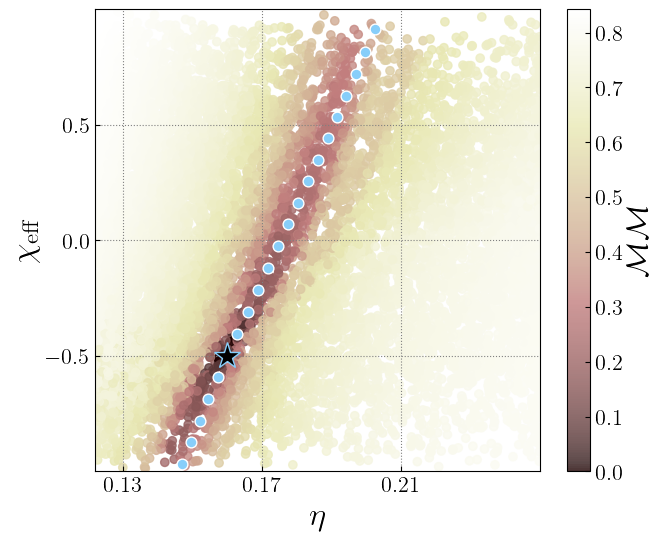

In [7]:
plot(mapper1, lam0, ndims, dimensions)

# Mapping in aligned space $\left[q, \chi_{1 z}, \chi_{2 z}\right]$

In [8]:
ndims = 3
dimensions = ['q', 'z1', 'z2']
mapper2 = run(lam0, ndims, dimensions, stepsize = 0.4, SNR = 7)

100%|██████████| 10000/10000 [00:00<00:00, 10749.20it/s]


####################################
MAPPING FORWARD DIRECTION
313/313 [==============================] - 0s 1ms/step
Size after rejection sampling: 191
Computing new vector
mapping to direction: [-0.33871902  0.32789476  0.14738451]
currently at  [4.0, -0.5, -0.5]
proposed start at  [ 3.92177619 -0.42427595 -0.46596301]
new start at  [ 3.92177619 -0.42427595 -0.46596301]
1/1 [==============================] - 0s 96ms/step
-----
313/313 [==============================] - 0s 1ms/step
Size after rejection sampling: 175
Computing new vector
mapping to direction: [-0.31951597  0.28304576  0.21618369]
currently at  [ 3.92177619 -0.42427595 -0.46596301]
proposed start at  [ 3.84798714 -0.35890933 -0.41603752]
new start at  [ 3.84798714 -0.35890933 -0.41603752]
1/1 [==============================] - 0s 103ms/step
-----
313/313 [==============================] - 0s 1ms/step
Size after rejection sampling: 197
Computing new vector
mapping to direction: [-0.36395985  0.34472204  0.14940907]
curre

100%|██████████| 9999/9999 [00:00<00:00, 20221.49it/s]


313/313 [==============================] - 0s 1ms/step


/tmp/ipykernel_3087508/25158644.py:84: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc,label= '$\mathcal{MM}$',fraction=0.13, cmap = cmap)


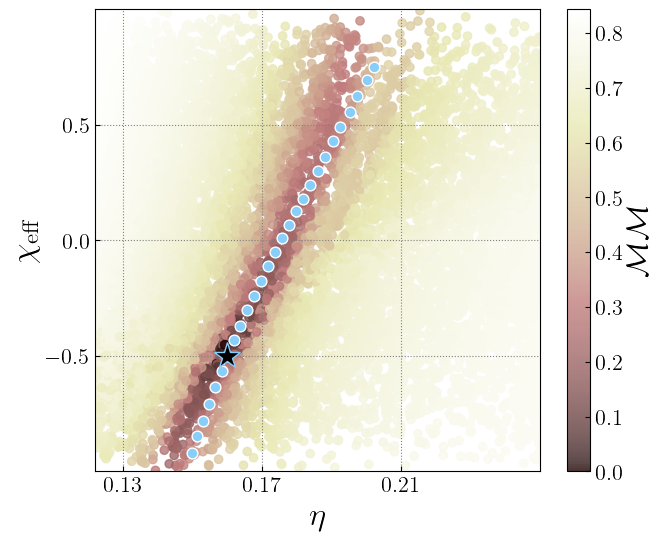

In [9]:
plot(mapper2, lam0, ndims, dimensions)

# Mapping in precession space $\left(\eta, \chi_1\right)$

### change $\lambda$ to only precession components (make sure all $z$- components are 0)

In [10]:
lam0 = [0.16, 0.5, 0, 0, 0, 0, 0]

In [11]:
ndims = 2
dimensions = ['eta', 'inplane1']
mapper3 = run(lam0, ndims, dimensions, stepsize = 0.2, SNR = 10)

100%|██████████| 10000/10000 [00:00<00:00, 12255.63it/s]


####################################
MAPPING FORWARD DIRECTION
313/313 [==============================] - 0s 1ms/step
Size after rejection sampling: 202
Computing new vector
mapping to direction: [0.00076772 0.24617635]
currently at  [0.16, 0.5]
proposed start at  [0.16010857 0.53481459]
new start at  [0.16010857 0.53481459]
1/1 [==============================] - 0s 97ms/step
-----
313/313 [==============================] - 0s 1ms/step
Size after rejection sampling: 196
Computing new vector
mapping to direction: [0.00085929 0.25016522]
currently at  [0.16010857 0.53481459]
proposed start at  [0.16023009 0.5701933 ]
new start at  [0.16023009 0.5701933 ]
1/1 [==============================] - 0s 84ms/step
-----
313/313 [==============================] - 0s 1ms/step
Size after rejection sampling: 205
Computing new vector
mapping to direction: [0.00077363 0.25848226]
currently at  [0.16023009 0.5701933 ]
proposed start at  [0.1603395  0.60674821]
new start at  [0.1603395  0.60674821]
1/1 [

100%|██████████| 9999/9999 [00:00<00:00, 18073.61it/s]


313/313 [==============================] - 0s 1ms/step


/tmp/ipykernel_3087508/25158644.py:84: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc,label= '$\mathcal{MM}$',fraction=0.13, cmap = cmap)


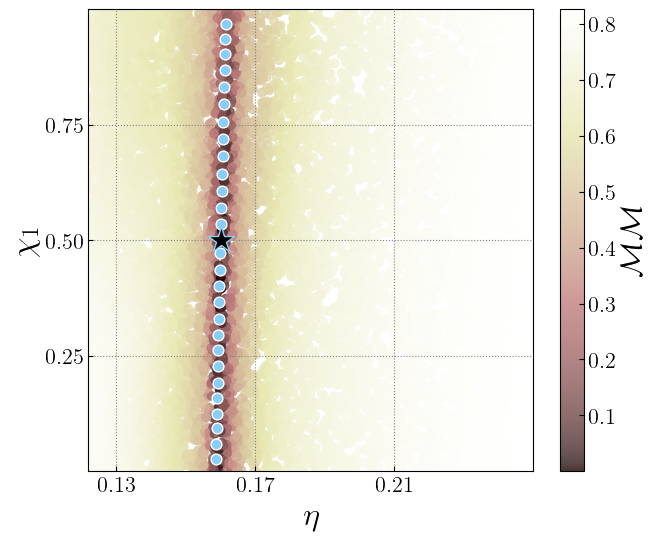

In [12]:
plot(mapper3, lam0, ndims, dimensions)